## basics

- 基本概念及术语
    - algorithm
        - policy iteration
            - policy gradient
        - value iteration
            - sarsa： state, action, reward, state, action
                - Q-table：待学习（learning/iteration update)
                    - row index: state; column index: action;
                    - 不是概率分布，是 value
            - q-learning
    - reward
        - 特定时间 $t$ 给到的奖励 $R_t$ 称为即时奖励（immediate reward）
        - 未来的总奖励 $G_t$
            - $G_t=R_{t+1}+R_{t+2}+R_{t+3}+\cdots$
            - $G_t=R_{t+1}+\gamma R_{t+2}+\gamma^2R_{t+3} + \cdots + \gamma^kR_{t+k+1}\cdots$
        - 举例
            - $Q_\pi(s=7,a=1)=R_{t+1}=1$
            - $Q_\pi(s=7,a=0)=\gamma^2$
    - action value，state value
    - bellman equation
        - 适用于状态价值函数（state value function），也适用于动作价值函数（action value function）
    - mdp：markov decision process
        - 马尔可夫性
            - $p(s_{t+1}|s_t)=p(s_{t+1}|{s_1,s_2,s_3,\cdots,s_t})$
        - bellman equation 成立的前提条件

- $R_t$
- $Q_{\pi}(s,a)$：state action value function
    - Q table
    - 通过 Sarsa 算法迭代更新 $Q_{\pi}(s,a)$
- 对于强化学习而言
    - state, action, reward 都是需要精心设计的

In [1]:
import os
import sys
sys.path.append("..") 

import numpy as np
import gym
import matplotlib.pyplot as plt

from env import MazeEnv

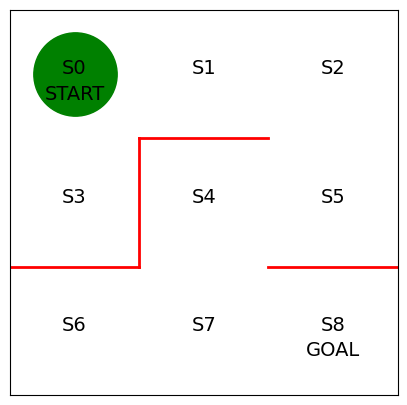

In [2]:
Maze = MazeEnv()
Maze.draw_maze()

## Sarsa（state action reward state action）

In [3]:
theta_0 = Maze.theta_0
theta_0

array([[nan,  1.,  1., nan],
       [nan,  1., nan,  1.],
       [nan, nan,  1.,  1.],
       [ 1., nan, nan, nan],
       [nan,  1.,  1., nan],
       [ 1., nan, nan,  1.],
       [nan,  1., nan, nan],
       [ 1.,  1., nan,  1.]])

In [4]:
n_states, n_actions = theta_0.shape
print(n_states, n_actions)

8 4


In [5]:
# Q table, 状态是离散的（s0-s7），动作也是离散的（上右下左）
Q = np.random.rand(n_states, n_actions) * theta_0
Q

array([[       nan, 0.34989531, 0.09377609,        nan],
       [       nan, 0.57211486,        nan, 0.89606416],
       [       nan,        nan, 0.81574568, 0.20931604],
       [0.12203388,        nan,        nan,        nan],
       [       nan, 0.45696831, 0.27513254,        nan],
       [0.41301134,        nan,        nan, 0.50203102],
       [       nan, 0.350279  ,        nan,        nan],
       [0.17118371, 0.83325554,        nan, 0.2572154 ]])

### $\epsilon$-greedy (explore, exploit)

In [6]:
# 基于占比, 最 naive 的概率化方式
def cvt_theta_0_to_pi(theta):
    m, n = theta.shape
    pi = np.zeros((m, n))
    for r in range(m):
        pi[r, :] = theta[r, :] / np.nansum(theta[r, :])
    return np.nan_to_num(pi)

In [7]:
pi_0 = cvt_theta_0_to_pi(theta_0)
print("Q:\n", Q)
print("")
print("pi_0:\n", pi_0)

Q:
 [[       nan 0.34989531 0.09377609        nan]
 [       nan 0.57211486        nan 0.89606416]
 [       nan        nan 0.81574568 0.20931604]
 [0.12203388        nan        nan        nan]
 [       nan 0.45696831 0.27513254        nan]
 [0.41301134        nan        nan 0.50203102]
 [       nan 0.350279          nan        nan]
 [0.17118371 0.83325554        nan 0.2572154 ]]

pi_0:
 [[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [0.         0.5        0.5        0.        ]
 [0.5        0.         0.         0.5       ]
 [0.         1.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.33333333]]


In [8]:
# epsilon-greedy
def get_action(s, Q, eps, pi_0):
    action_space = list(range(4))
    # eps, explore
    if np.random.rand() < eps:
        action = np.random.choice(action_space, p=pi_0[s, :])
    else:
        # 1-eps, exploit
        action = np.nanargmax(Q[s, :])
    return action

### Sarsa (update $Q_\pi(s,a)$)

理想情况下：
$$
Q(s_t,a_t) = R_{t+1}+\gamma Q(s_{t+1}, a_{t+1})
$$

- td (temporal difference error)
    - $R_{t+1}+\gamma Q(s_{t+1},a_{t+1})-Q(s_t,a_t)$
- final update equation
    - $Q(s_t,a_t)=Q(s_t,a_t)+\eta\cdot(R_{t+1}+\gamma Q(s_{t+1},a_{t+1})-Q(s_t,a_t))$
    - $s_t,a_t,r_{t+1},s_{t+1},a_{t+1}$

- 折扣（discount factor，$\gamma$）
    - 有助于缩短步数（更快地结束任务）；

In [9]:
def sarsa(s, a, r, s_next, a_next, Q, eta, gamma):
    if s_next == 8:
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])

## 解决 maze 问题

In [10]:
# 动作策略选择，基于当前环境的状态
class Agent:
    def __init__(self):
        self.theta_0 = Maze.theta_0
        self.action_space = Maze.theta_0.shape[1]
        self.pi = self._cvt_theta_to_pi()

        self.Q = np.random.rand(*self.theta_0.shape) * self.theta_0
        self.eta = 0.1
        self.gamma = 0.9
        self.eps = 0.5
        
    def _cvt_theta_to_pi(self):
        m, n = self.theta_0.shape
        pi = np.zeros((m, n))
        for r in range(m):
            pi[r, :] = self.theta_0[r, :] / np.nansum(self.theta_0[r, :])
        return np.nan_to_num(pi)
    
    def get_action(self, s):
        # eps, explore
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space, p=self.pi[s, :])
        else:
            # 1-eps, exploit
            action = np.nanargmax(self.Q[s, :])
        return action
        
    def sarsa(self, s, a, r, s_next, a_next):
        if s_next == 8:
            self.Q[s, a] = self.Q[s, a] + self.eta * (r - self.Q[s, a])
        else:
            self.Q[s, a] = self.Q[s, a] + self.eta * (r + self.gamma * self.Q[s_next, a_next] - self.Q[s, a])

## 完成训练及更新

In [11]:
maze = MazeEnv()
agent = Agent()
epoch = 0
while True:
    old_Q = np.nanmax(agent.Q, axis=1)
    s = maze.reset()
    a = agent.get_action(s)
    s_a_history = [[s, np.nan]]
    while True:
        # s, a 
        s_a_history[-1][1] = a
        s_next, reward, done, _ = maze.step(a, )
        # s_next, a_next
        s_a_history.append([s_next, np.nan])
        if done:
            a_next = np.nan
        else:
            a_next = agent.get_action(s_next)
        agent.sarsa(s, a, reward, s_next, a_next)
        if done:
            break
        else:
            a = a_next
            s = maze.state

    # s_s_history, agent.Q
    update = np.sum(np.abs(np.nanmax(agent.Q, axis=1) - old_Q))
    epoch +=1
    agent.eps /= 2
    print(epoch, update, len(s_a_history))
    if epoch > 100 or update < 1e-5:
        break


1 0.43598373199671925 15
2 0.8825775266145559 87
3 0.06675718187469049 9
4 0.0918353761459948 21
5 0.0579611817431635 7
6 0.05172430316187698 7
7 0.048923679380193597 7
8 0.046381332136924636 7
9 0.040582123142860416 9
10 0.043258236896090096 7
11 0.04192680449641151 7
12 0.040449504711834616 7
13 0.038862097240446536 7
14 0.03719451095217313 7
15 0.03547180042645798 7
16 0.03371494342637871 7
17 0.03194150432718185 7
18 0.031384141934462984 7
19 0.030825979658889502 7
20 0.030183195487137382 7
21 0.029469160158267893 7
22 0.02869594596804259 7
23 0.02787441821330111 7
24 0.027195072356330674 7
25 0.026914988143926344 7
26 0.02661026199632527 7
27 0.02628125742698567 7
28 0.025928630339657976 7
29 0.02555327808485619 7
30 0.025156294526517353 7
31 0.02473893051978915 7
32 0.024302559241910326 7
33 0.02384864586272134 7
34 0.02337872108691258 7
35 0.022894358144895766 7
36 0.02239715285198285 7
37 0.02188870639560081 7
38 0.02137061054717526 7
39 0.020844435028848807 7
40 0.020311716795

In [12]:
agent.Q

array([[       nan, 0.58036865, 0.36036943,        nan],
       [       nan, 0.65157999,        nan, 0.38383458],
       [       nan,        nan, 0.72736733, 0.34518972],
       [0.32778508,        nan,        nan,        nan],
       [       nan, 0.5626639 , 0.89991693,        nan],
       [0.4243333 ,        nan,        nan, 0.80955204],
       [       nan, 0.41164269,        nan,        nan],
       [0.6379488 , 0.99999219,        nan, 0.13554405]])

## 可视化

In [13]:
Maze.draw_videos(s_a_history)